# Train LTSM model with time series data

Problem: predict lap time D laps in the future in a new event based on the historical event data.

In this experiment, we treat the lap time info for each car a time series and bulid lstm model on it.


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models, layers
import time
from sklearn.preprocessing import MinMaxScaler
# to use only one GPU.
# use this on r-001
# otherwise comment
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
from indycar.notebook import *

Using TensorFlow backend.


### Load data and Initialization

In [2]:
os.getcwd()

'/scratch/hpda/indycar/predictor/notebook/CalculateRank'

In [3]:
#datalist = ['2017-all_completed_laps_diff.csv','2018-all_completed_laps_diff.csv' ]
datalist = ['2017-Indy500-completed_laps_diff.csv','2018-Indy500-completed_laps_diff.csv' ]
flaglist = ['2017-Indy500-flagstatus.csv','2018-Indy500-flagstatus.csv' ]
#datalist = read_list('train_all.list')
#datalist = read_list('train_completed.list')

# predict D lap in the future
D = 1 
# hidden utnits for LSTM
hunits = 16
shuffle_flag = False
use_flag_status = False
epochs = 500
lossfunc='mse'  #; 'mse'

#model name: (shuffle)_(flaginfo)_(epochs)_(hunits)_(lossfunc)
model_name = 'lstmts_s%s_f%s_i%s_h%s_%s'%(1 if shuffle_flag else 0,
                            1 if use_flag_status else 0,
                            epochs, hunits, lossfunc)

output_prefix = 'indy500-train2017-test2018-completed_laps-M%s-D%d'%(model_name, D)
pred_outputfile = output_prefix + '-pred.csv'
model_outputfile = output_prefix + '-model.h5'
trainhist_outputfile = output_prefix + '-trainhist.jpg'


scaler, dataset, dblens = load_data(datalist)

dataset.info(verbose=True)
print('dataset shape', dataset.shape)

load 2017-Indy500-completed_laps_diff.csv, len=3216
load 2018-Indy500-completed_laps_diff.csv, len=3618
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6834 entries, 0 to 3617
Data columns (total 10 columns):
MyIdx             6834 non-null int64
car_number        6834 non-null int64
completed_laps    6834 non-null int64
rank              6834 non-null int64
elapsed_time      6834 non-null float64
rank_diff         6834 non-null float64
time_diff         6834 non-null float64
dbid              6834 non-null int64
rank_diff_raw     6834 non-null float64
time_diff_raw     6834 non-null float64
dtypes: float64(5), int64(5)
memory usage: 587.3 KB
dataset shape (6834, 10)


In [4]:
# generate train/test dataset

# post-padding with 0
X, y, w = generate_data(dataset, D=D, target='time', shuffle=shuffle_flag)

carNumber = 34, max T =201


In [5]:
def load_flaginfo(flaglist):
    flaginfo = []
    for f in flaglist:
        data = pd.read_csv(f)
        # 0 if yellow flag set
        flaginfo.append(np.array(data['track_status']!='Y'))
        
    return flaginfo
        
# weight set by flag status
if use_flag_status:
    laps = w.shape[1]
    flaginfo = load_flaginfo(flaglist)
    start, end = 0, 0
    for id,flagdata in enumerate(flaginfo):
        end = start + dblens[id]
        flag = flagdata[:laps].reshape((1,-1))
        nw = np.multiply(w[start:end,:], flag)
        w[start:end,:] = nw
        
        start = end
    
    #
    print('size of flaginfo', len(flaginfo[0]))
    flaginfo[1]

In [6]:
w[dblens[0]]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [7]:
#w = w*100 + 0.1

In [8]:
# train/test split
total = np.sum(dblens)
ntrain = np.sum(dblens[:-1])
nval = int(dblens[-1] / 2)
print('train=%d, val=%d, test=%d'%(ntrain, nval, total-ntrain-nval))

X_train, X_val, X_test = X[:ntrain], X[ntrain:ntrain + nval], X[ntrain + nval:]
y_train, y_val, y_test = y[:ntrain], y[ntrain:ntrain + nval], y[ntrain + nval:]
#weights
w_train, w_val, w_test = w[:ntrain], w[ntrain:ntrain + nval], w[ntrain+nval:]
print('train shape:', X_train.shape)

train=16, val=9, test=9
train shape: (16, 200, 1)


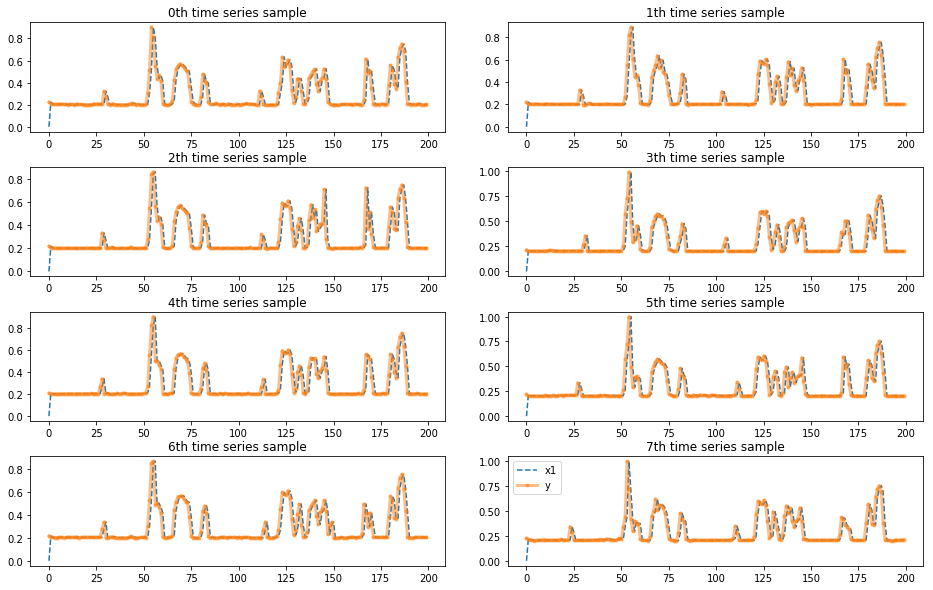

In [9]:
#
# plot one car time series for each event
#
idx = np.arange(8)
plot_examples(X[idx],y[idx],ypreds=None,nm_ypreds=None)
#plot_examples(X[:10],y[:10],ypreds=None,nm_ypreds=None)

## Define model

In [10]:
#
# https://fairyonice.github.io/Stateful-LSTM-model-training-in-Keras.html
#
def define_model(len_ts,
                 hidden_neurons = 10,
                 nfeature=1,
                 batch_size=None,
                 stateful=False,
                 lossfunc='mse'):
    in_out_neurons = 1
    
    inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  

    rnn = layers.LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful=stateful,
                    name="RNN")(inp)

    dens = layers.TimeDistributed(layers.Dense(in_out_neurons,name="dense"))(rnn)
    model = models.Model(inputs=[inp],outputs=[dens])
    
    if lossfunc == 'mae':
        model.compile(loss="mean_absolute_error",
                  sample_weight_mode="temporal",
                  optimizer="adam")
    elif lossfunc == 'mse':
        model.compile(loss="mean_squared_error",
                  sample_weight_mode="temporal",
                  optimizer="rmsprop")
    else:
        print('error, loss func not support yet', losssfunc)
    
    
    return(model,(inp,rnn,dens))

In [11]:

model_stateless, _ = define_model(
                    hidden_neurons = hunits,
                    len_ts = X_train.shape[1],
                    lossfunc=lossfunc)
model_stateless.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 200, 1)            0         
_________________________________________________________________
RNN (LSTM)                   (None, 200, 16)           1152      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 200, 1)            17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


### train for 500 epochs


In [12]:
start = time.time()
history = model_stateless.fit(X_train,y_train,
                             batch_size=8,
                             shuffle=True,
                             epochs=epochs,
                             verbose=0,
                             sample_weight=w_train,
                             validation_data=(X_val,y_val,w_val))
end = time.time()
print("Time Took :{:3.2f} min".format( (end-start)/60 ))


Time Took :3.93 min


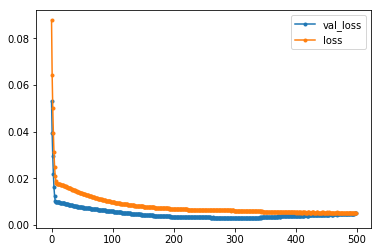

In [13]:
for line in history.history.keys():
    plt.plot(history.history[line],marker='.',label=line)
plt.legend()
plt.savefig(trainhist_outputfile)

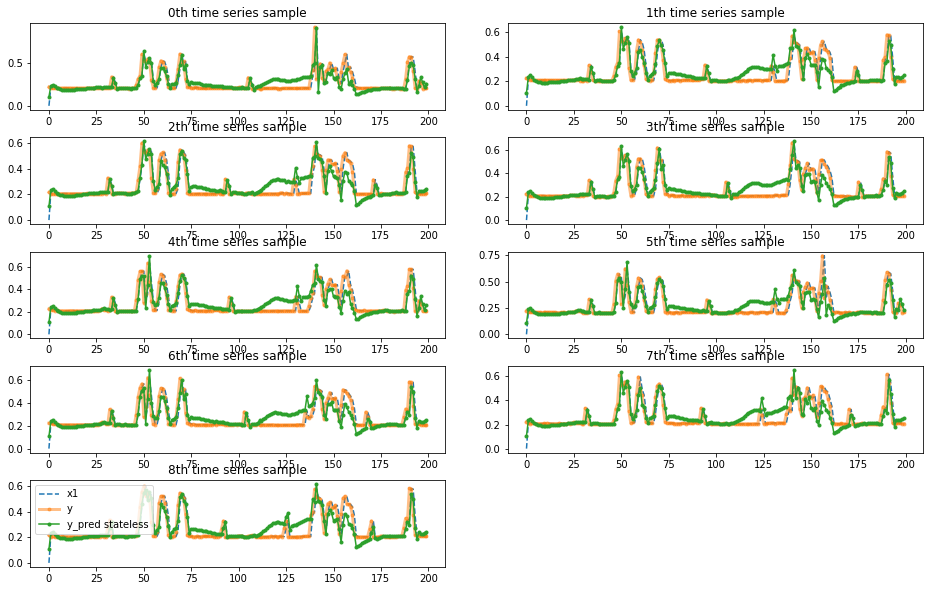

In [14]:
y_pred_stateless = model_stateless.predict(X_test)
plot_examples(X_test,y_test,ypreds=[y_pred_stateless],nm_ypreds=["y_pred stateless"])

In [15]:
lstmts_result = predict('lstmts', model_stateless, X_test, y_test, scaler)
print(lstmts_result[0][:10])

lstmts model mae=0.050762, raw mae=5.122987, raw mape=9.119817
[0.10627985 0.23847128 0.24813625 0.23049958 0.21483947 0.2058585
 0.19650227 0.19190261 0.19016333 0.19040798]


In [16]:
lstmts_result[0][20:60], y_test[0,20:60].flatten()

(array([0.20443906, 0.20771429, 0.21100125, 0.21046923, 0.212657  ,
        0.21744226, 0.22144431, 0.21792936, 0.21581982, 0.21813685,
        0.22114038, 0.21862614, 0.22284347, 0.21813278, 0.32844394,
        0.2644107 , 0.20309363, 0.20841864, 0.21028589, 0.20756513,
        0.20551643, 0.20464744, 0.20461442, 0.2034499 , 0.20558925,
        0.20683195, 0.20859191, 0.2507454 , 0.3255014 , 0.35222554,
        0.6464536 , 0.4620793 , 0.5128401 , 0.5639487 , 0.50934964,
        0.28928208, 0.24943213, 0.2664278 , 0.32123575, 0.44093832],
       dtype=float32),
 array([0.20909393, 0.21083341, 0.20747088, 0.20830371, 0.21244506,
        0.21580858, 0.20999909, 0.2064805 , 0.20844144, 0.21167714,
        0.2088804 , 0.21470722, 0.21012048, 0.34148144, 0.2770341 ,
        0.20965675, 0.20572496, 0.20556246, 0.20535388, 0.20489362,
        0.20480692, 0.20532267, 0.20426789, 0.20584734, 0.20604006,
        0.20566105, 0.24371898, 0.31834903, 0.35527984, 0.60992418,
        0.5270481 , 0.52

In [17]:
#save result
#def save_pred_result(lstmts_result[0], scaler):
Y_pred = lstmts_result[1]
df = pd.DataFrame({'pred':Y_pred[:,1]})
df.to_csv(pred_outputfile)

# save format
# carno -> predicts(lap times)

In [18]:
#save model
model_stateless.save(model_outputfile)

### Result Analysis

It is amazing to see the capacity of the model, which predicts the pikes of crashes ''accurately''.
However, the performance goes worse in the cases of pitstops. They are totally ignored.
Overfitting must occur here.
To verify that, let''s train on data of a different event, such as train on 2017 and then test on 2018. 
Another idea is to modify the loss funtion to emphysize on pitstops.



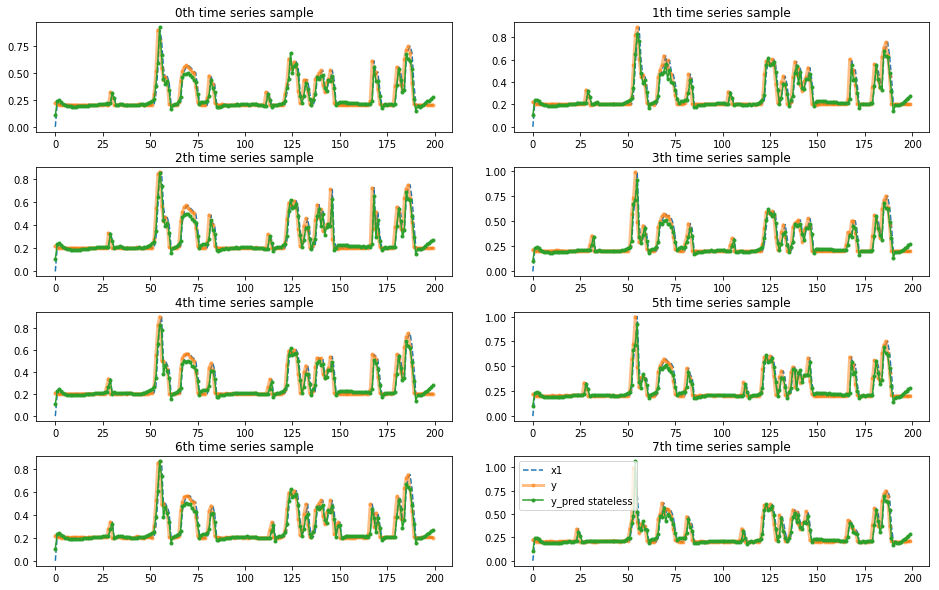

In [19]:
y_pred_stateless = model_stateless.predict(X_train)

#idx_train = idx[:-1]
idx_train = np.arange(8)
plot_examples(X_train[idx_train],y_train[idx_train],ypreds=[y_pred_stateless[idx_train]],nm_ypreds=["y_pred stateless"])

### conclusion


